# Data Analysis of Olivocerebellar Model

## Table of Contents

1. Import All
    1. Import packages
    1. Import data of simulations
2. Clean up Data
3. Connectivity Graph
4. Raster Plots
    1. Single Loop (1PC - 10DCN- 1 IO)
    2. Entire Circuitry (10PC - 10DCN - 20IO)
5. Purkinje Cell
    1. Input Current
    2. Seperate Input Current
6. Inferior Olive
    1. Spike Time Comparison

In [1]:
# 1.1) Import packages
import numpy as np
from importlib import reload
from brian2 import*
import pickle
import NeuroTools as nt
from NeuroTools import signals, analysis
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.io as sio
import seaborn as sns
import matplotlib.patches as mpatches
import h5py
#import plotpy.express as px
%matplotlib notebook

# Import and reload my helpers module for iterative development
import helpers
reload(helpers)
from helpers.Function_DataAnalysis import *
#from helpers.bin import *

# default dict. to assign values
from collections import defaultdict

# Open File , NOTE: Always close the file (last cell in the notebook!)

All_data = h5py.File('Single_frequencyInput_1to20.hdf5','a')

<KeysViewHDF5 ['adapted', 'initial', 'plasticity']>
<KeysViewHDF5 ['Input', 'PV', 'Population_rate', 'Spikes', 'Voltage_Cells']>
<KeysViewHDF5 ['DCN_coupled', 'DCN_uncoupled', 'IO_coupled', 'IO_uncoupled', 'PC_coupled', 'PC_uncoupled']>
[ 0.         -0.04151822 -0.03733359 ... -0.07044976 -0.07042505
 -0.07037051]
[ 0.         -0.04151836 -0.03733412 ... -0.06249391 -0.06230598
 -0.0620979 ]


<IPython.core.display.Javascript object>


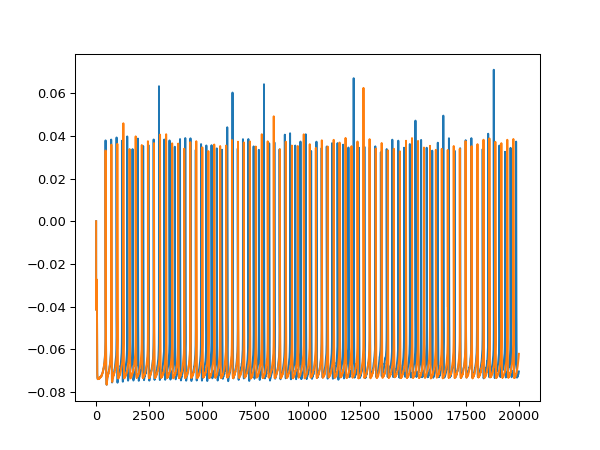

In [2]:
print(All_data['2and2Hz'].keys())
print(All_data['2and2Hz']['plasticity'].keys())
print(All_data['1and1Hz']['adapted']['Spikes'].keys())
print(All_data['2and2Hz']['plasticity']['Voltage_Cells']['IOsoma_coupled'][0])
print(All_data['2and2Hz']['plasticity']['Voltage_Cells']['IOsoma_uncoupled'][0])

plt.figure()
plt.plot(All_data['2and2Hz']['plasticity']['Voltage_Cells']['IOsoma_coupled'][0])
plt.plot(All_data['2and2Hz']['plasticity']['Voltage_Cells']['IOsoma_uncoupled'][0])
plt.show()
#print(All_data['2Hz']['plasticity']['Spikes'].keys())
#long_term_20Hz = All_data['20Hz']['plasticity']['PV']['Long_term_.f_coupled'][1]
#long_term_2Hz = All_data['2Hz']['plasticity']['PV']['Long_term_f_coupled'][1]
#names= All_data['2Hz'].create_dataset('test',data=(10,))

## 2. Clean up Data
### The first 5 seconds, no input is given to the system. This is not of interest for the analysis and is therefore removed from the dataset

In [31]:
start = 5000 # remove first second of data due to transient behavior
sP = All_data['2and2Hz']['plasticity']['Input']

t_beforeAdaptation = int(len(sP['I'][1])/2)
print(t_beforeAdaptation)


# Get properties of the circuitry
#sP = All_data['2and2Hz']['plasticity']['Input']
#vP = All_data['2and2Hz']['plasticity']['Voltage_Cells']
#print(sP.keys())
#print(sP['Ir'])

nrIO=20
nrPC=10
nrDCN=20
#print('nr PC',nrPC, 'nrDCN',nrDCN, 'nrIO=',nrIO)

#lengthSim =len(All_data['1Hz']['adapted']['Voltage_Cells']['PC_coupled'][0])
#print(lengthSim)
# Find the peaks for IO spikes
#print(All_data['2Hz/plasticity/Spikes/IO_coupled'][0])
dt_type = h5py.vlen_dtype(np.dtype('float64'))

# the slicing of data only needs to happen once
# after that set SlicingDone to 'yes'
SlicingDone = 'no'
FindSpikes = 'yes'
SliceData = 'no'
SliceSpikes = 'no'
# Checklist
# 1. FindSpikes =='yes'
    # find IO spikes from the trace 
# 2. SliceData == 'yes'
    # Slice data from 5second on
    # Add 'r' to the name of the label
# 3. SliceSpikes == 'yes'
    # Cut the spikes >5
if SlicingDone == 'no':
    for i in All_data.keys():
        #print(i)
        for j in All_data[i].keys():
            #print(j)
            vP = All_data[i][j]['Voltage_Cells']
            sT = All_data[i][j]['Spikes']
            pR = All_data[i][j]['Population_rate']
            iP = All_data[i][j]['Input']
            #print(sT.keys())
            # create new dataset to write new values to
            if FindSpikes=='yes':
                sIOc = {}
                sIOu = {}
                for k in range(0,nrIO):
                    spikeio_BAc, _ = find_peaks(vP['IOsoma_coupled'][k], height=0.0, distance = 10) 
                    spikeio_BAuc, _ = find_peaks(vP['IOsoma_uncoupled'][k], height=0.0, distance = 10) 
                    spikeio_BAc = spikeio_BAc/1000
                    spikeio_BAuc = spikeio_BAuc/1000
                    
                    sIOc[k] = spikeio_BAc
                    sIOu[k] = spikeio_BAuc

                #print(sIOc)
                sIOc = list(sIOc.values())
                sIOu = list(sIOu.values())
                #print('spike times coupled',sIOc[1])
                #print('spike times uncoupled',sIOu[1])
                
                
                #sT_nu = sT.create_dataset('IO_uncoupled_no',data=sIOu,dtype=dt_type)
                try:
                    sT_nc = sT.create_dataset('IO_coupled_pir',data=sIOc,dtype=dt_type)
                    #print('nothing wrong',sIOc)
                except TypeError:
                    print(i,j)
                    #print('smth wrong',sIOc)
                    #print('smth right',sIOu)
                  #  break

            #print(sT_nc)
            # Slicing Spikes
            #print(len(SpikeTimes_AA['PC_coupled'][1]),SpikeTimes_AA['PC_coupled'][1])
            #All_data[i][j]['Spikes'] = SlicingSpikes(All_data[i][j]['Spikes'], t_start = start/1e3)

            if SliceData=='yes':
                print('slicing data')
                vP = Slicing(vP,t_start=start)
                pR = Slicing(pR,t_start=start)
                iP = Slicing(iP,t_start=start)
                #print(len(vP['PC_coupled'][0]))
                

            if SliceSpikes=='yes':
                
                #del sT['IO_uncoupled']
                #del sT['IO_coupled']
                try:
                    sT = SlicingSpikes(sT,t_start=start/1e3)
                    #sT = All_data[i][j]['Spikes']
                    #del sT['DCN_coupledq']
                    #del sT['DCN_coupledr']
                    #del sT['DCN_coupledrr']
                    #del sT['DCN_uncoupledq']
                    #del sT['DCN_uncoupledr']
                    #del sT['DCN_uncoupledrr']
                    #del sT['PC_coupledq']
                    #del sT['PC_coupledr']
                    #del sT['PC_coupledrr']
                    #del sT['PC_uncoupledq']
                    #del sT['PC_uncoupledr']
                    #del sT['PC_uncoupledrr']
                    #del sT['IO_coupledq']
                    #del sT['IO_coupledr']
                    #del sT['IO_coupledrr']
                    #del sT['IO_uncoupledq']
                    #del sT['IO_uncoupledr']
                    #del sT['IO_uncoupledrr']
                    #del iP['Ir']
                    #del iP['I_InputPC_coupledr']
                    #del iP['I_InputPC_uncoupledr']
                    #del iP['weightr']
                    #del pR['PC_coupledr']
                    #del pR['PC_uncoupledr']
                    #del pR['DCN_coupledr']
                    #del pR['DCN_uncoupledr']
                    #del pR['IO_coupledr']
                    #del pR['IO_uncoupledr']
                    #del sT['PC_coupledrr']
                    #del sT['PC_uncoupledrr']
                    #del sT['DCN_uncoupledrr']
                    #del sT['DCN_coupledrr']
                    #del sT['IO_uncoupledrerr']
                    #del sT['IO_coupledrerr']
                    print('treid')
                except KeyError:
                    print('KeyError occured')
                    continue

            #sT = SlicingSpikes(sT,t_start=start/1e3)
            
            
            #sT = SlicingSpikes(sT)

        #sT = SlicingSpikes(sT,t_start=start/1e3)
        #print(sT)
        #for label in vP.keys():
        #    nrCell = len(vP[label])
        #    if nrCell > 1000:
        #        vP[label][...] = vP[label][int(t_start/0.025):t_end]
        #    else:
        #        vP[label][...] = [vP[label][k][t_start:t_end] for k in range(0,nrCell)]

        #print(len(vP['PC_coupled'][0]))
        #print(x)
        #print(x.)
        #All_data[i][j]['Voltage_Cells'] = x
        #iP = Slicing(iP,t_start=start)

#lengthSim =len(All_data['1Hz']['adapted']['Voltage_Cells']['PC_coupledr'][0])
#print(lengthSim)

# Usefull parameters 
#nrInputs = len(sP['Ir'])
#nrPC = len(vP['PC_coupledr'])
#nrDCN = len(vP['DCN_coupledr'])
#nrIO = len(vP['IOsoma_coupledr'])
#nrDummy = nrPC*nrInputs

10000
11and11Hz plasticity
18and18Hz plasticity
4and4Hz plasticity
6and6Hz plasticity
8and8Hz plasticity


In [54]:
vP = All_data['11and11Hz/plasticity/Voltage_Cells']
sT = All_data['11and11Hz/plasticity/Spikes']
print(sT.keys())
print(vP.keys())
sIOc = {}
dt_type = h5py.vlen_dtype(np.dtype('float64'))

sIOu = {}
for k in range(0,nrIO):

    spikeio_BAc, _ = find_peaks(vP['IOsoma_coupled'][k], height=0.0, distance = 10) 
    spikeio_BAuc, _ = find_peaks(vP['IOsoma_uncoupled'][k], height=0.0, distance = 10) 
    #print(spikeio_BAc)
    spikeio_BAc = spikeio_BAc/1000
    spikeio_BAuc = spikeio_BAuc/1000

    sIOc[k] = spikeio_BAc
    sIOu[k] = spikeio_BAuc
#print(sIOc)
#print(sIOu)
#print(sIOc)
sIOc = list(sIOc.values())
sIOu = list(sIOu.values())
print(type(sIOc))
print(type(sIOu))
#print(sIOu)
#print('spike times coupled',sIOc[1])
#print('spike times uncoupled',sIOu[1])


#sT_nu = sT.create_dataset('IO_uncoupled_no',data=sIOu,dtype=dt_type)

sT_nc = sT.create_dataset('IO_coupled_plpr',data=sIOc,dtype=dt_type)
    #print('nothing wrong',sIOc)


<KeysViewHDF5 ['DCN_coupled', 'DCN_uncoupled', 'IO_coupled', 'IO_coupled_pfr', 'IO_coupled_plpr', 'IO_coupled_ppr', 'IO_coupled_yyr', 'IO_uncoupled', 'IO_uncoupled_n', 'IO_uncoupled_no', 'PC_coupled', 'PC_uncoupled']>
<KeysViewHDF5 ['DCN_coupled', 'DCN_uncoupled', 'IOsoma_coupled', 'IOsoma_uncoupled', 'PC_coupled', 'PC_uncoupled']>
<class 'list'>
<class 'list'>


TypeError: Operation not defined for data type class (operation not defined for data type class)

In [ ]:
nrInputs = len(sP['Ir'])
nrPC = len(vP['PC_coupledr'])
nrDCN = len(vP['DCN_coupledr'])
nrIO = len(vP['IOsoma_coupledr'])
nrDummy = nrPC*nrInputs

In [ ]:
print(All_data['2and2Hz/plasticity/Spikes'].keys())
#print(All_data['2and2Hz/plasticity/Voltage_Cells'].keys())

print(len(All_data['2and2Hz/plasticity/Population_rate/PC_coupledr']))
print(len(All_data['2and2Hz/plasticity/Population_rate/DCN_coupledr']))
print(All_data['2and2Hz/plasticity/Spikes/DCN_coupledr'][7])
print(All_data['2and2Hz/plasticity/Spikes/IO_coupled_nr'][7])

## 3. Connectivity Graph

In [ ]:
if nrInputs == 5 :
    # Input - Dummy
    i_ind = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
    j_ind = np.arange(nrDummy)
    Connectivity(i_ind,j_ind,'Input','Dummy')

    # Dummy-PC
    i_dPC = np.arange(nrInputs*nrPC)
    j_dPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_dPC,i_dPC,'PC','Dummy')
    # IO - dummy 
    i_IOd = [9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11, 9, 10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOd=np.arange(nrInputs*nrPC)
    Connectivity(i_IOd,j_IOd,'IO','Dummy')
    # IO - PC
    i_IOPC = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_IOPC,i_IOPC,'PC','IO')
    # DCN - IO
    i_DCNIO = [0, 0 ,0, 0 ,0,0 ,0, 0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,11 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,13 ,14 ,14 ,14 ,14,14 ,14 ,14 ,14 ,14 ,14 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,16 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,17 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,19 ,19,19 ,19 ,19 ,19 ,19 ,19 ,19 ,19]
    j_DCNIO = [5 ,7, 10, 15 ,4 ,6 ,9 ,3 ,1, 11 ,8 ,4 ,11, 17, 14 ,9 ,3 ,2 ,0, 15 ,0 ,3 ,7 ,2 ,9 ,10, 19, 17 ,4 ,14 ,2 ,8, 16 ,3 ,5, 19, 12 ,0, 18, 17, 12 ,9 ,6, 10, 13 ,3 ,4 ,2, 15, 18 ,2, 14, 19, 18, 16, 17 ,5 ,8 ,4 ,9, 14 ,6 ,8, 16, 12, 19 ,4 ,5 ,0 ,3, 16 ,9,13 ,1, 17 ,0 ,8, 14 ,7, 10, 10 ,6, 13 ,1 ,4, 18 ,8, 12, 17 ,0 ,7, 11 ,3 ,1 ,9, 10,6, 17, 13, 18 ,8, 16 ,7 ,1 ,6, 12, 10, 19, 15 ,4, 12 ,2 ,4 ,1, 19, 13, 17, 16 ,8 ,9, 12 ,4 ,3 ,1 ,0 ,8 ,2, 11, 14, 13, 10, 17, 12, 13, 16, 11 ,4 ,2 ,8 ,5, 15, 17, 13, 19, 14 ,1 ,4, 16 ,6 ,3 ,5, 16 ,0, 19 ,2 ,9, 18 ,6 ,4 ,1, 10 ,8, 15 ,3 ,0 ,1 ,4, 13, 19 ,7 ,3 ,9, 14, 18, 16, 17 ,5, 19, 11, 10, 11 ,6, 15, 10 ,5, 12, 17 ,4 ,8, 16, 14 ,8,
     10, 15, 4, 11 ,2 ,7 ,5, 18]
    Connectivity(i_DCNIO,j_DCNIO,'DCN','IO')

    # PC - DCN
    i_PCDCN = [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,2 ,3 ,3 ,3 ,3 ,3 ,3 ,3
     ,3 ,3 ,3 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,4 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,5 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,6 ,7 ,7 ,7 ,7
     ,7 ,7 ,7 ,7 ,7 ,7 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,8 ,9 ,9 ,9 ,9 ,9 ,9 ,9 ,9 ,9 ,9]
    j_PCDCN = [15, 10, 18 ,3 ,8 ,7 ,1 ,4, 16 ,2 ,4, 14, 12, 10 ,2, 13 ,3 ,0, 15, 16 ,5 ,9 ,0, 13,14, 11, 15, 17, 16, 10, 16 ,1, 13, 17 ,9 ,3 ,5, 10, 12, 18 ,4, 12, 18 ,2 ,5, 13, 15 ,7 ,1 ,6 ,8, 16, 17 ,1, 13, 12, 15 ,7 ,4 ,2, 17 ,0, 14 ,7 ,3, 19 ,4 ,9 ,5 ,2, 18 ,4 ,0, 11, 15 ,3 ,9 ,1 ,8 ,2 ,19 ,1 ,11, 10 ,6 ,0 ,9, 17, 12 ,3 ,7, 11, 17 ,1 ,2, 14,5 ,4, 12 ,0]
    Connectivity(i_PCDCN,j_PCDCN,'PC','DCN')
elif nrInputs == 2:
    # Input-dummy
    i_ind = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    j_ind = np.arange(nrInputs*nrPC)
    Connectivity(i_ind,j_ind,'Input','Dummy')
    # dummy-PC
    i_dPC = np.arange(nrInputs*nrPC)
    j_dPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_dPC,i_dPC,'PC','Dummy')

    # IO - dummy
    i_IOd = [9,10, 18, 17, 0, 6, 5, 12, 16, 11, 9,10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOd=np.arange(nrInputs*nrPC)
    Connectivity(i_IOd,j_IOd,'IO','Dummy')

    # IO - PC
    i_IOPC = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]
    j_IOPC = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Connectivity(j_IOPC,i_IOPC,'PC','IO')

    # DCN - IO
    i_DCNIO = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,19,19,19,19,19,19,19,19,19,19]

    j_DCNIO =[8 , 19 , 10 ,  3 , 12 , 17 ,  11 ,  5 , 13 ,  14 , 11 ,  0 , 13 ,7 , 10 , 12 , 17 ,  9 ,  8 ,  3 ,  4 , 11 ,  7 ,  0 ,  6 ,  9 ,8 , 12 , 19 , 14 ,  4 ,  3 , 16 ,  0 ,  7 ,  1 , 14 ,  5 , 18 ,17 , 19 , 18 ,  1 , 15 ,  2 , 14 ,  8 ,  7 ,  0 ,  3 , 16 , 13 ,11 ,  5 ,  2 , 10 ,  8 ,  0 ,  7 , 18 , 16 , 11 ,  7 ,  0 ,  6 ,5 ,  9 , 18 , 13 ,  4 , 15 ,  0 , 17 ,  6 ,  8 ,  7 , 14 ,  9 ,18 ,  4 , 17 ,  7 , 14 , 13 ,  3 ,  1 ,  2 ,  8 , 16 ,  9 , 10 ,13 ,  1 ,  5 , 11 , 12 ,  4 , 15 ,  8 , 14 ,  7 ,  1 , 19 , 15 ,2 ,  6 , 14 ,  4 , 16 , 12 , 15 ,  2 ,  5 ,  0 , 17 , 14 , 19 ,13 , 16 ,  6 , 10 ,  9 , 18 , 12 ,  1 ,  6 ,  4 ,  2 , 19 ,  5 ,8 , 17 ,  5 , 15 , 14 , 18 , 10 , 16 ,  3 , 12 ,  3 , 10 , 12 ,13 , 15 ,  9 , 19 , 16 ,  1 ,  2 ,  2 , 11 ,  1 , 10 ,  4 , 17 ,16 , 15 ,  6 , 18 ,  6 , 13 ,  1 ,  9 ,  5 ,  3 ,  4 , 17 , 18 ,10 , 18 , 17 ,  9 , 10 , 19 ,  6 , 12 , 11 , 15 , 13 ,  0 ,  2 ,16 ,  1 ,  3 ,  4 , 19 , 15 , 11 ,  5 , 12 ,  9 ,  7 , 11 ,  8 ,0 ,  2 ,  6 ,  3 , 19]
    #[11,4,8,9,14,10,1,7,17,6,9,18,1,0,5,3,6,4,13,2,17,15,4,2,10,16,18,13,19,8,10,4,8,6,3,17,2,19,16,11,19,11,15,2,7,8,4,17,10,1,16,12,15,13,3,0,4,11,1,18,11,8,18,17,12,15,2,5,0,6,15,9,6,8,14,4,18,3,19,12,19,4,14,3,1,11,13,8,15,17,14,16,8,9,11,1,17,2,18,19,12,18,19,10,7,2,13,14,4,5,2,8,5,7,0,13,15,18,6,10,16,3,8,15,1,12,4,7,9,2,10,2,8,5,12,19,16,14,15,4,10,17,13,5,0,18,8,15,4,11,5,12,6,4,2,17,19,14,10,3,17,10,1,15,3,4,7,13,5,16,9,3,15,11,12,0,4,5,7,18,18,2,0,3,9,15,13,1,17,8,14,18,17,3,7,8,9,6,5,13]
    Connectivity(i_DCNIO,j_DCNIO,'DCN','IO')

    # PC - DCN
    i_PCDCN = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9]
    j_PCDCN = [8,17,13,9,11,14,4,16,1,0,17,5,13,2,3,19,4,7,6,8,15,18,2,8,7,11,0,10,16,17,4,16,19,11,18,7,10,8,5,0,0,17,11,13,3,6,1,8,5,10,19,17,12,15,14,4,8,10,18,11,8,6,1,4,16,5,18,3,2,9,3,9,18,11,14,15,4,17,19,10,6,15,10,5,0,11,9,17,12,2,18,0,3,7,2,16,19,10,5,13]
    Connectivity(i_PCDCN,j_PCDCN,'PC','DCN')

## 4. Raster Plots

1. Before Adaptation
    1. Coupled
    2. Uncoupled
    3. Single Loop Coupled
    4. Sinlge Loop Uncoupled
1. After Adaptation
    1. Coupled
    2. Uncoupled
    3. Single Loop Coupled
    4. Single Loop Uncoupled

In [ ]:
# Set up the parameters for the visualisation

Frequency = '20and20Hz'  # the input frequency
typeRun = 'adapted'  # choose from: initial (run with no plasticity)
                        # plasticity (run with plasticity and change of weights)
                        # adapted (run with no plasticity, final weights of 'plasticity'-run)
DataSelect = All_data[Frequency][typeRun]

## BEFORE ADAPTATION ##
# Coupled
PopRate = DataSelect['Population_rate']
SpikeTimes = DataSelect['Spikes']
Input = DataSelect['Input']
print(PopRate.keys())
t=np.linspace(5,20,num=int(len(PopRate['DCN_coupledr']))) # time 
print(t)
fig, axs = plt.subplots(6, 1,figsize=(15,15))

# subplot 1: population frequency PC
ax1= plt.subplot(6,1,1)
plt.title('coupled')
plt.plot(t,PopRate['PC_coupledr'])
plt.ylabel('PC population f')
# subplot 2: population frequency DCN
ax2 = plt.subplot(612, sharex=ax1)
plt.plot(t,PopRate['DCN_coupledr'])
plt.ylabel('DCN population f')

# subplot 3: population frequency IO
ax3 = plt.subplot(613,sharex = ax1)
plt.plot(t,PopRate['IO_coupledr'])
plt.ylabel('IO population f')
plt.show()

# Raster plot PC
for i in range(0,nrPC):
    ax3 = plt.subplot(6,1,4, sharex=ax1)
    ax3.set_ylabel('PC Index [-]')
    neu = SpikeTimes['PC_coupledr'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')

# Raster Plot DCN
for i in range(0,nrDCN):
    ax4 = plt.subplot(6,1,5, sharex=ax1)
    ax4.set_ylabel('DCN Index [-]')
    neu = SpikeTimes['DCN_coupledr'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')

# Raster Plot IO
for i in range(0,nrIO):
    ax5 = plt.subplot(6,1,6, sharex=ax1)
    ax5.set_ylabel('IO Index [-]')
    neu = SpikeTimes['IO_coupled_nr'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')
    
## BEFORE ADAPTATION ##
# Uncoupled



In [ ]:
fig, axs = plt.subplots(6, 1,figsize=(15,15))

# subplot 1: population frequency PC
ax1= plt.subplot(6,1,1)
plt.title('uncoupled')
plt.plot(t,PopRate['PC_uncoupledr'])
plt.ylabel('PC population f')
# subplot 2: population frequency DCN
ax2 = plt.subplot(612, sharex=ax1)
plt.plot(t,PopRate['DCN_uncoupledr'])
plt.ylabel('DCN population f')

# subplot 3: population frequency IO
ax3 = plt.subplot(613,sharex = ax1)
plt.plot(t,PopRate['IO_uncoupledr'])
plt.ylabel('IO population f')

# Raster plot PC
for i in range(0,nrPC):
    ax3 = plt.subplot(6,1,4, sharex=ax1)
    ax3.set_ylabel('PC Index [-]')
    neu = SpikeTimes['PC_uncoupledr'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')

# Raster Plot DCN
for i in range(0,nrDCN):
    ax4 = plt.subplot(6,1,5, sharex=ax1)
    ax4.set_ylabel('DCN Index [-]')
    neu = SpikeTimes['DCN_uncoupledr'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')

# Raster Plot IO
for i in range(0,nrIO):
    ax5 = plt.subplot(6,1,6, sharex=ax1)
    ax5.set_ylabel('IO Index [-]')
    neu = SpikeTimes['IO_uncoupled_nr'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')

In [ ]:
# Raster Plot Single Loop 
print(Input.keys())
lengthSim = len(All_data['2Hz']['plasticity']['Voltage_Cells']['PC_coupledr'][0])
RasterPlot(SpikeTimes['IO_coupled'][9],SpikeTimes['PC_coupled'][0],SpikeTimes['DCN_coupled'],
           'yes',int(lengthSim), Input['I_InputPC_coupledr'][0])
RasterPlot(SpikeTimes['IO_uncoupled'][9],SpikeTimes['PC_uncoupled'][0],SpikeTimes['DCN_uncoupled'],
           'yes',int(lengthSim), Input['I_InputPC_uncoupledr'][0])

In [ ]:
build='yes'

freqstr = [str(i)+'and'+str(i)+'Hz' for i in range(1,21)]
#print(freqstr)
xpos = np.arange(20)+1
#print(xpos)

# total empty allocation
ch_c = np.zeros((20,10))
ch_uc = np.zeros((20,10))

# mean empty allocation
pp_c = np.zeros((20,))
pp_u = np.zeros((20,))
std_c = np.zeros((20,))
std_uc = np.zeros((20,))

lo=0
for k in freqstr:
    fwc = All_data[k]['plasticity/PV']['final_weights_coupled']
    fwu = All_data[k]['plasticity/PV']['final_weights_uncoupled']
    pp_c[lo] = np.mean(fwc)/0.5
    pp_u[lo] = np.mean(fwu)/0.5

    ch_c[lo,:] = np.asarray(fwc[0:10])/0.5
    ch_uc[lo,:] = np.asarray(fwu[0:10])/0.5

    std_c[lo] = np.std(fwc)
    std_uc[lo] = np.std(fwu)
    lo = lo+1
#print(ch_c)
# Build the plot
if build == 'yes':
    fig, ax = plt.subplots()
    w=0.3
    ax.bar(xpos+w/2, pp_c, yerr=std_c, align='center', alpha=1, ecolor='black', capsize=10, width=w, color='r')
    ax.bar(xpos-w/2, pp_u, yerr=std_uc, align='center', alpha=0.5, ecolor='black', capsize=10, width=w, color='g')
    ax.set_ylabel('Normalized changed of weight ($-$)')
    #ax.autoscale(tight=True)
    ax.set_xticks(xpos)
    ax.set_xlabel('Input frequency [Hz]')
    ax.set_ylim([0.8,1.2])
    #ax.set_xticklabels(materials)
    ax.set_title('Mean change of weight PC-PF synapse - Coupled vs Uncoupled')
    ax.yaxis.grid(True)
    ax.legend(['Coupled','Uncoupled'])

    plt.figure()
    plt.scatter(xpos,std_uc, color='g')
    plt.scatter(xpos,std_c, color='r')
    plt.legend(['Uncoupled','Coupled'])
    plt.xlabel('Input frequency [Hz]')
    plt.ylabel('Standard deviation [-]')
    plt.show()
elif build == 'heatmap':
    plt.figure()
    plt.title('Relative weight change - Coupled')
    nf = sns.heatmap(ch_c,center=1, cmap='jet', linewidths=.5,
                  annot=False)
    plt.ylabel('Input frequency [Hz]')
    plt.xlabel('PC index [-]')

    plt.figure()
    plt.title('Relative weight change - Uncoupled')
    nfu = sns.heatmap(ch_uc,center=1, cmap='jet', linewidths=.5,
                 annot=False)
    plt.ylabel('Input frequency [Hz]')
    plt.xlabel('PC index [-]')


## x. Purkinje Cell Input

In [ ]:
InputCurrentPC={}
InputCurrentPC_BA_coupled={}
InputCurrentPC_BA_uncoupled={}

InputCurrentPC_AA_coupled={}
#print(size(Input_AA['nweight'],0))
for i in range(0,nrPC):
    # Create names for the inputs
    name = 'PC'+str(i)
    nameBA_coupled = 'PC'+str(i) + 'BA_coupled'
    nameBA_uncoupled = 'PC'+str(i) + 'BA_uncoupled'
    
    nameAA_coupled = 'PC'+str(i)+'AA_coupled'
    
    weightBA_coupled = 'WeightPC'+str(i)+'BA_coupled'
    weightBA_uncoupled = 'WeightPC'+str(i)+'BA_uncoupled'
    
    weightAA_coupled=  'WeightPC'+str(i)+'AA_coupled'
    
    tot = name + 'total'
    totBA_coupled = nameBA_coupled + 'total'
    totBA_uncoupled = nameBA_uncoupled + 'total'
    
    totAA_coupled = nameAA_coupled+'total'
    
    # Connectivity between PC-dummy
    steps =np.arange(i,nrDummy,nrPC)
    #print(steps)
    # Multiply the current times the weight
    #current = [Input['I'][k]*Input['nweight'][steps[k]] for k in range(0,len(steps))]
    #currentBA = [Input_BA['I'][k]*Input_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    weight_BA_coupled = [InputPC_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    weight_BA_uncoupled = [InputPC_BA['nweight'][steps[k]] for k in range(0,len(steps))]

    weight_AA_coupled = [InputPC_AA['nweight'][steps[k]] for k in range(0,len(steps))]

    currentBA_coupled = [InputPC_BA['I'][k]*InputPC_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    currentBA_uncoupled = [InputPC_BA['I'][k]*InputPC_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    
    currentAA_coupled = [InputPC_AA['I'][k]*InputPC_AA['nweight'][steps[k]] for k in range(0,len(steps))]

    #[Input_s.nweight_BA[steps[k]]*Input_s.I_BA[k] for k in range(0,len(steps))]
    #print(steps[1])
    #print(size(Input_s.nweight_BA[0]))
    #print(size(current))
    # Sum over the column to get the total amount of current
    #summedcurrent = sum(current,axis=0)
    summedcurrentBA_coupled = sum(currentBA_coupled, axis=0)
    summedcurrentBA_uncoupled = sum(currentBA_uncoupled, axis=0)
    
    summedcurrentAA_coupled = sum(currentAA_coupled, axis=0)
    
    #InputCurrentPC[name] = current
    InputCurrentPC_BA_coupled[nameBA_coupled] = currentBA_coupled
    InputCurrentPC_BA_uncoupled[nameBA_uncoupled] = currentBA_uncoupled
    
    InputCurrentPC_AA_coupled[nameAA_coupled] = currentAA_coupled

    # weights seperate
    InputCurrentPC_BA_coupled[weightBA_coupled] = weight_BA_coupled
    InputCurrentPC_BA_uncoupled[weightBA_uncoupled] = weight_BA_uncoupled
    
    InputCurrentPC_AA_coupled[weightAA_coupled] = weight_AA_coupled

    #InputCurrentPC[tot] = summedcurrent
    InputCurrentPC_BA_coupled[totBA_coupled] = summedcurrentBA_coupled
    InputCurrentPC_BA_uncoupled[totBA_uncoupled] = summedcurrentBA_uncoupled
    
    InputCurrentPC_AA_coupled[totAA_coupled] = summedcurrentAA_coupled


In [ ]:
import elephant.conversion as conv
import elephant.spike_train_correlation as spiketrain
import neo as n
import quantities as pq
#print(All_data['2Hz/plasticity/Spikes'].keys())
freq = [str(i)+'and'+str(i)+'Hz' for i in range(1,2)]

types = ['initial','plasticity','adapted']
coupling =['IO_coupled', 'IO_uncoupled']
#SD = All_data['2Hz/plasticity/Spikes/IO_coupledq']
binsiz = 0.1
#1/4/10
l=0

qq = 1

for tt in freq:
    for kk in coupling:
        fig, axs = plt.subplots(1,3, figsize=(12,4),sharex=True,sharey=True)
        fig.suptitle('Sum Xcorr IO cells - Input = ' + str(qq) + 'Hz - ' + ' '+ kk)
    
        y=0
        
        for nn in types:

            #print(All_data[freq][nn].keys())
            #print(All_data[freq][nn]['Spikes'].keys())
            SD = All_data[tt][nn]['Spikes'][kk+'_nr']
            print('spike time IO'+kk+ str(SD[1][5]))
            corrl = int(15/binsiz)*2-1
            st={}
            delay=np.empty((20,20))
            total_corr = np.empty((size(types)*size(coupling)*size(freq),corrl))
            #print(total_corr)
            pp = np.zeros((corrl,1))
            for p in range(0,20):
                x = n.SpikeTrain(SD[p]*pq.s,t_stop=20.0*pq.s)
                st[str(p)] = conv.BinnedSpikeTrain(x,binsize=binsiz*pq.s,t_start=5*pq.s)
            for ii in range(0,1):
                for k in range(0,1):
                    crosscorr = spiketrain.cross_correlation_histogram(st[str(ii)],st[str(k)])
                    #print(crosscorr)
                    pp += crosscorr[0]
                    #plt.figure()
                    #plt.plot(crosscorr[0])
                    #plt.show()
                    #print(crosscorr)
                    delay[ii,k] = np.argmax(crosscorr[0])
            ppp =np.reshape(pp,(int(15/binsiz)*2-1,))
            total_corr[l,:]= ppp
            delay = (delay-((15)/binsiz))*binsiz
            #plt.figure()
            #plt.title('Delay of IO cells with respect to other IO cells -' + nn)
            #plt.xlabel('IO index [-]')
            #plt.ylabel('IO index [-]')
            #sns.heatmap(delay,center = 0, cmap='jet')
            #plt.show()
            #plt.figure()
            #plt.title('Sum of Xcorr for all IO cell w.r.t eachother - '+kk+ nn +
            #         'Input being :' + tt)
            #plt.xlabel('Data bins [-]')
            #plt.ylabel('Correlation [-]')
            
            
            axs[y].plot(total_corr[l,:])
            axs[y].title.set_text(nn)
            #plt.ylim([0,400])
            #plt.xlim([])
            #plt.xlim(delay-20*corrl,delay+20*corrl)
            #plt.show()

            y += 1
            l += 1
        plt.savefig(tt+'correlation_'+kk+'_'+nn)
    qq += 1


In [ ]:
print(All_data['3and3Hz/adapted/Spikes/IO_coupled_nr'][1])
print(All_data['3and3Hz/adapted/Spikes/IO_uncoupled_nr'][1])

In [ ]:
#6.1 Input Current Purkinje Cell
# Get the current that the Purkinje cell sees 1000 ms before and 1000 ms after
# a complex spike of the connected Inferior Olive

# Select which frequency you want analyzed
freq = '2and2Hz'

InputBA = All_data[freq]['initial/Input']
InputAA = All_data[freq]['adapted/Input']
VoltBA = All_data[freq]['initial/Voltage_Cells']
VoltAA = All_data[freq]['adapted/Voltage_Cells']
SpikesBA = All_data[freq]['initial/Spikes']
SpikesAA = All_data[freq]['adapted/Spikes']

# The IO cells that are connected to the Purkinje cells.
# Position 1 of the vector corresponds to PC1, 2 to PC2 etc.
connectionVectorIO = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]

time_before_spike = 1000e-3
time_after_spike = 1000e-3
CS_currentPC=defaultdict(dict)
duration = int((time_before_spike+time_after_spike)*1e3)

# Create empty arrays to fill the mean current before and after the CS
meancur_BA_coupled=np.zeros((nrPC,duration))
meancur_BA_uncoupled=np.zeros((nrPC,duration))
meancur_AA_coupled=np.zeros((nrPC,duration))
meancur_AA_uncoupled=np.zeros((nrPC,duration))

#sep_curBA_coupled=np.zeros((nrPC*2,duration))
#sep_curAA_coupled=np.zeros((nrPC*2,duration))

# Empty arrays of voltage cells of IOs
mean_voltIO_AA_coupled = np.zeros((nrPC,duration))
mean_voltIO_BA_coupled = np.zeros((nrPC,duration))
mean_voltIO_AA_uncoupled = np.zeros((nrPC,duration))
mean_voltIO_BA_uncoupled = np.zeros((nrPC,duration))

#weight_BA_coupled = np.zeros((nrInputs*nrPC,duration))
#weight_AA_coupled = np.zeros((nrInputs*nrPC,duration))

### !! FOR NOW COUPLED AND UNCOUPLED ARE THE SAME INPUT (BOTH SAME FREQ) !! ###
InpPCBA_coupled = InputBA['I_InputPC_coupled']
InpPCBA_uncoupled = InputBA['I_InputPC_uncoupled']

InpPCAA_coupled = InputAA['I_InputPC_coupled']
InpPCAA_uncoupled = InputAA['I_InputPC_uncoupled']

for jj in range(0,nrPC):
    strp = str(connectionVectorIO[jj])
    #pcnr = 'PC'+str(jj)+'BA_coupled'
    #pcnr2 = 'PC'+str(jj)+'AA_coupled'
    #w_pcnr = 'WeightPC'+str(jj)+'BA_coupled'
    #w2_pcnr = 'WeightPC'+str(jj)+'AA_coupled'

    # Input current I_Noise to PC
    InputCurrBA = InpPCBA_coupled[jj]
    InputCurrAA = InpPCAA_coupled[jj]

    # Seperate Inputs (after weight multiplication)
    #sep_inpba=InputCurrentPC_BA_coupled[pcnr]
    #sep_inpaa=InputCurrentPC_AA_coupled[pcnr2]

    # Get weights
    #sep_wBA =InputCurrentPC_BA_coupled[w_pcnr]
    #sep_wAA = InputCurrentPC_AA_coupled[w2_pcnr]

    # Membrane potential of IO cells
    voltIO_BA_coupled = VoltBA['IOsoma_coupled'][connectionVectorIO[jj]]
    voltIO_BA_uncoupled = VoltBA['IOsoma_uncoupled'][connectionVectorIO[jj]]

    voltIO_AA_coupled = VoltAA['IOsoma_coupled'][connectionVectorIO[jj]]
    voltIO_AA_uncoupled = VoltAA['IOsoma_uncoupled'][connectionVectorIO[jj]]

    # The complex spikes times
    CS_BA_coupled= SpikesBA['IO_coupled'][connectionVectorIO[jj]]
    CS_BA_uncoupled = SpikesBA['IO_uncoupled'][connectionVectorIO[jj]]
    CS_AA_coupled = SpikesAA['IO_coupled'][connectionVectorIO[jj]]
    CS_AA_uncoupled = SpikesAA['IO_uncoupled'][connectionVectorIO[jj]]

    # initialization of empty array which are assigned in the loop below
    I_BA_coupled = np.zeros((len(CS_BA_coupled),duration))
    I_BA_uncoupled = np.zeros((len(CS_BA_uncoupled),duration))
    I_AA_coupled =np.zeros((len(CS_AA_coupled),duration))
    I_AA_uncoupled =np.zeros((len(CS_AA_uncoupled),duration))

    empt_curBA_coupled =np.zeros((len(CS_BA_coupled)*nrInputs,duration))
    empt_curBA_uncoupled =np.zeros((len(CS_BA_uncoupled)*nrInputs,duration))

    empt_curAA_coupled =np.zeros((len(CS_AA_coupled)*nrInputs,duration))
    empt_curAA_uncoupled =np.zeros((len(CS_AA_uncoupled)*nrInputs,duration))

    empt_membIO_BA_coupled = np.zeros((len(CS_BA_coupled),duration))
    empt_membIO_BA_uncoupled = np.zeros((len(CS_BA_uncoupled),duration))

    empt_membIO_AA_coupled = np.zeros((len(CS_AA_coupled),duration))
    empt_membIO_AA_uncoupled = np.zeros((len(CS_AA_uncoupled),duration))
    #empt_membIO_AA = np.zeros((len(CS_AA),duration))

    #empt_wAA = np.zeros((len(CS_AA)*nrInputs,duration))
    #empt_wBA = np.zeros((len(CS_BA)*nrInputs,duration))

    k=0
    #plt.figure()
    #plt.title('Before adapation')
    for ii in range(0,len(CS_BA_coupled)):
        begin_analysis = max(int(((CS_BA_coupled[ii]-time_before_spike)/1e-3)),CS_BA_coupled[0]*1000)-start
        end_analysis = (int((min((CS_BA_coupled[ii]+time_after_spike)/1e-3,
                        CS_BA_coupled[-1]*1000))))-start
        if end_analysis-begin_analysis==duration-1 :
            end_analysis=end_analysis+1
        elif end_analysis-begin_analysis==duration+1 :
            end_analysis=end_analysis-1
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis-abs(begin_analysis))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_BA_coupled[ii]= InputCurrBA[begin_analysis:end_analysis]

            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential
            empt_membIO_BA_coupled[ii] = voltIO_BA_coupled[begin_analysis:end_analysis]

    for kk in range(0,len(CS_BA_uncoupled)):
        begin_analysis_unc = max(int(((CS_BA_uncoupled[kk]-time_before_spike)/1e-3)),CS_BA_uncoupled[0]*1000)-start
        end_analysis_unc = (int((min((CS_BA_uncoupled[kk]+time_after_spike)/1e-3,
                        CS_BA_uncoupled[-1]*1000))))-start
        if end_analysis_unc-begin_analysis_unc==duration-1 :
            end_analysis_unc=end_analysis_unc+1
        elif end_analysis_unc-begin_analysis_unc==duration+1 :
            end_analysis_unc=end_analysis_unc-1
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis_unc-abs(begin_analysis_unc))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_BA_uncoupled[kk]= InputCurrBA[begin_analysis_unc:end_analysis_unc]

            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential
            empt_membIO_BA_uncoupled[kk] = voltIO_BA_uncoupled[begin_analysis_unc:end_analysis_unc]
    #plt.figure()
    for pp in range(0,len(CS_AA_coupled)):
        begin_analysis = max(int(((CS_AA_coupled[pp]-time_before_spike)/1e-3)),CS_AA_coupled[0]*1000)-start
        end_analysis = (int((min((CS_AA_coupled[pp]+time_after_spike)/1e-3,
                        CS_AA_coupled[-1]*1000))))-start
        if end_analysis-begin_analysis==duration-1 :
            end_analysis=end_analysis+1
        elif end_analysis-begin_analysis==duration+1 :
            end_analysis=end_analysis-1
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis-abs(begin_analysis))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_AA_coupled[pp]= InputCurrAA[begin_analysis:end_analysis]
            #plt.plot(I_AA_coupled[pp])
            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential
            empt_membIO_AA_coupled[pp] = voltIO_AA_coupled[begin_analysis:end_analysis]
    #plt.show()
    for ll in range(0,len(CS_AA_uncoupled)):
        begin_analysis_unc = max(int(((CS_AA_uncoupled[ll]-time_before_spike)/1e-3)),CS_AA_uncoupled[0]*1000)-start
        end_analysis_unc = (int((min((CS_AA_uncoupled[ll]+time_after_spike)/1e-3,
                        CS_AA_uncoupled[-1]*1000))))-start
        if end_analysis_unc-begin_analysis_unc==duration-1 :
            end_analysis_unc=end_analysis_unc+1
        elif end_analysis_unc-begin_analysis_unc==duration+1 :
            end_analysis_unc=end_analysis_unc-1
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis_unc-abs(begin_analysis_unc))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_AA_uncoupled[ll]= InputCurrAA[begin_analysis_unc:end_analysis_unc]

            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential
            empt_membIO_AA_uncoupled[ll] = voltIO_AA_uncoupled[begin_analysis_unc:end_analysis_unc]
    I_AA_uncoupled = I_AA_uncoupled[~all(I_AA_uncoupled==0,axis=1)]
    I_AA_coupled = I_AA_coupled[~all(I_AA_coupled==0,axis=1)]
    I_BA_uncoupled = I_BA_uncoupled[~all(I_BA_uncoupled==0,axis=1)]
    I_BA_coupled = I_BA_coupled[~all(I_BA_coupled==0,axis=1)]

    mean_voltIO_AA_coupled[jj] = np.mean(empt_membIO_AA_coupled,axis=0)
    mean_voltIO_AA_uncoupled[jj] = np.mean(empt_membIO_AA_uncoupled,axis=0)
    mean_voltIO_BA_coupled[jj] = np.mean(empt_membIO_BA_coupled,axis=0)
    mean_voltIO_BA_uncoupled[jj] = np.mean(empt_membIO_BA_uncoupled,axis=0)

    meancur_BA_coupled[jj]=np.mean(I_BA_coupled,axis=0)
    meancur_BA_uncoupled[jj]=np.mean(I_BA_uncoupled,axis=0)
    meancur_AA_coupled[jj]=np.mean(I_AA_coupled,axis=0)
    meancur_AA_uncoupled[jj]=np.mean(I_AA_uncoupled,axis=0)

In [ ]:
fig, axs = subplots(5, 2,figsize=(20,10))
fig.suptitle('Kernel of Input for CS - Coupled')
p=q=0
#figure(figsize=(20,20))
#fig(figsize=(20,10))
#print(meancur_BA_coupled)
time = linspace(start=-time_before_spike*1e3,stop=time_after_spike*1e3,num=duration)
for i in range(0,len(meancur_BA_coupled)):
    #subplot(5,2,i+1)
    axs[p,q].plot(time,meancur_BA_coupled[i], color='cyan')
    axs[p,q].plot(time,meancur_AA_coupled[i], color='black')

    axs[p,q].axvline(0, linewidth=2,color='r')
    axs[p,q].set_title('Mean input current to PC' + str(i))
    p=p+1
    if i==4:
        q=q+1
        p=0
    for ax in axs.flat:
        ax.set(xlabel='time [ms]', ylabel='current [A]')
    for ax in axs.flat:
        ax.label_outer()
    #axs.figsize((20,10))
legend(['before','after','cs'], loc='lower left')
show()
savefig(freq+'kernel_coupled')

fig, axs = subplots(5, 2,figsize=(20,10))
fig.suptitle('Kernel of Input for CS - Uncoupled')
p=q=0
#figure(figsize=(20,20))
#fig(figsize=(20,10))
#print(meancur_BA_coupled)
time = linspace(start=-time_before_spike*1e3,stop=time_after_spike*1e3,num=duration)
for i in range(0,len(meancur_BA_coupled)):
    #subplot(5,2,i+1)
    axs[p,q].plot(time,meancur_BA_uncoupled[i], color='cyan')
    axs[p,q].plot(time,meancur_AA_uncoupled[i], color='black')

    axs[p,q].axvline(0, linewidth=2,color='r')
    axs[p,q].set_title('Mean input current to PC' + str(i))
    p=p+1
    if i==4:
        q=q+1
        p=0
    for ax in axs.flat:
        ax.set(xlabel='time [ms]', ylabel='current [A]')
    for ax in axs.flat:
        ax.label_outer()
    #axs.figsize((20,10))
legend(['before','after','cs'], loc='lower left')
show()
savefig(freq+'kernel_uncoupled')

## x. CS analysis

In [ ]:
#6.1 Input Current Purkinje Cell
# Get the current that the Purkinje cell sees 150 ms before and 50 ms after
# a complex spike of the connected Inferior Olive

# The IO cells that are connected to the Purkinje cells. 
# Position 1 of the vector corresponds to PC1, 2 to PC2 etc.
connectionVectorIO = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]

time_before_spike = 1000e-3
time_after_spike = 1000e-3
CS_currentPC=defaultdict(dict)
duration = int((time_before_spike+time_after_spike)*1e3)

# Create empty arrays to fill the mean current before and after the CS
meancur_BA_coupled=np.zeros((nrPC,duration))
meancur_BA_uncoupled=np.zeros((nrPC,duration))
meancur_AA_coupled=np.zeros((nrPC,duration))
meancur_AA_uncoupled=np.zeros((nrPC,duration))

#sep_curBA_coupled=np.zeros((nrPC*2,duration))
#sep_curAA_coupled=np.zeros((nrPC*2,duration))

# Empty arrays of voltage cells of IOs
mean_voltIO_AA_coupled = np.zeros((nrPC,duration))
mean_voltIO_BA_coupled = np.zeros((nrPC,duration))
mean_voltIO_AA_uncoupled = np.zeros((nrPC,duration))
mean_voltIO_BA_uncoupled = np.zeros((nrPC,duration))

#weight_BA_coupled = np.zeros((nrInputs*nrPC,duration))
#weight_AA_coupled = np.zeros((nrInputs*nrPC,duration))

### !! FOR NOW COUPLED AND UNCOUPLED ARE THE SAME INPUT (BOTH SAME FREQ) !! ###
InpPCBA_coupled = InputPC_BA['I_InputPC']
InpPCAA_coupled = InputPC_AA['I_InputPC']

for jj in range(0,nrPC):
    strp = str(connectionVectorIO[jj])
    #pcnr = 'PC'+str(jj)+'BA_coupled'
    #pcnr2 = 'PC'+str(jj)+'AA_coupled'
    #w_pcnr = 'WeightPC'+str(jj)+'BA_coupled'
    #w2_pcnr = 'WeightPC'+str(jj)+'AA_coupled'
    
    # Input current I_Noise to PC
    InputCurrBA = InputPC_BA['I_InputPC'][jj]
    InputCurrAA = InputPC_AA['I_InputPC'][jj]
 
    # Seperate Inputs (after weight multiplication)
    #sep_inpba=InputCurrentPC_BA_coupled[pcnr]
    #sep_inpaa=InputCurrentPC_AA_coupled[pcnr2]
    
    # Get weights 
    #sep_wBA =InputCurrentPC_BA_coupled[w_pcnr]
    #sep_wAA = InputCurrentPC_AA_coupled[w2_pcnr]
    
    # Membrane potential of IO cells
    voltIO_BA_coupled = VoltCells_BA['IOsoma_coupled'][connectionVectorIO[jj]]
    voltIO_BA_uncoupled = VoltCells_BA['IOsoma_uncoupled'][connectionVectorIO[jj]]

    voltIO_AA_coupled = VoltCells_AA['IOsoma_coupled'][connectionVectorIO[jj]]
    voltIO_AA_uncoupled = VoltCells_AA['IOsoma_uncoupled'][connectionVectorIO[jj]]
    
    # The complex spikes times
    CS_BA_coupled= SpikeTimes_BA['IO_coupled'][connectionVectorIO[jj]]
    CS_BA_uncoupled = SpikeTimes_BA['IO_uncoupled'][connectionVectorIO[jj]]
    CS_AA_coupled = SpikeTimes_AA['IO_coupled'][connectionVectorIO[jj]]
    CS_AA_uncoupled = SpikeTimes_AA['IO_uncoupled'][connectionVectorIO[jj]]
   
    # initialization of empty array which are assigned in the loop below
    I_BA_coupled = np.zeros((len(CS_BA_coupled),duration))
    I_BA_uncoupled = np.zeros((len(CS_BA_uncoupled),duration))
    I_AA_coupled =np.zeros((len(CS_AA_coupled),duration))
    I_AA_uncoupled =np.zeros((len(CS_AA_uncoupled),duration))

    empt_curBA_coupled =np.zeros((len(CS_BA_coupled)*nrInputs,duration))
    empt_curBA_uncoupled =np.zeros((len(CS_BA_uncoupled)*nrInputs,duration))

    empt_curAA_coupled =np.zeros((len(CS_AA_coupled)*nrInputs,duration))
    empt_curAA_uncoupled =np.zeros((len(CS_AA_uncoupled)*nrInputs,duration))

    empt_membIO_BA_coupled = np.zeros((len(CS_BA_coupled),duration))
    empt_membIO_BA_uncoupled = np.zeros((len(CS_BA_uncoupled),duration))

    empt_membIO_AA_coupled = np.zeros((len(CS_AA_coupled),duration))
    empt_membIO_AA_uncoupled = np.zeros((len(CS_AA_uncoupled),duration))
    #empt_membIO_AA = np.zeros((len(CS_AA),duration))
    
    #empt_wAA = np.zeros((len(CS_AA)*nrInputs,duration))
    #empt_wBA = np.zeros((len(CS_BA)*nrInputs,duration))

    k=0
    #plt.figure()
    #plt.title('Before adapation')
    for ii in range(0,len(CS_BA_coupled)):
        begin_analysis = max(int(((CS_BA_coupled[ii]-time_before_spike)/1e-3)),CS_BA_coupled[0]*1000)-start
        end_analysis = (int((min((CS_BA_coupled[ii]+time_after_spike)/1e-3,
                        CS_BA_coupled[-1]*1000))))-start
        if end_analysis-begin_analysis==duration-1 : 
            end_analysis=end_analysis+1
        elif end_analysis-begin_analysis==duration+1 : 
            end_analysis=end_analysis-1        
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis-abs(begin_analysis))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_BA_coupled[ii]= InputCurrBA[begin_analysis:end_analysis]
           
            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential 
            empt_membIO_BA_coupled[ii] = voltIO_BA_coupled[begin_analysis:end_analysis]
           
    for kk in range(0,len(CS_BA_uncoupled)):
        begin_analysis_unc = max(int(((CS_BA_uncoupled[kk]-time_before_spike)/1e-3)),CS_BA_uncoupled[0]*1000)-start
        end_analysis_unc = (int((min((CS_BA_uncoupled[kk]+time_after_spike)/1e-3,
                        CS_BA_uncoupled[-1]*1000))))-start
        if end_analysis_unc-begin_analysis_unc==duration-1 : 
            end_analysis_unc=end_analysis_unc+1
        elif end_analysis_unc-begin_analysis_unc==duration+1 : 
            end_analysis_unc=end_analysis_unc-1        
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis_unc-abs(begin_analysis_unc))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_BA_uncoupled[kk]= InputCurrBA[begin_analysis_unc:end_analysis_unc]
           
            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential 
            empt_membIO_BA_uncoupled[kk] = voltIO_BA_uncoupled[begin_analysis_unc:end_analysis_unc]           
    #plt.figure()
    for pp in range(0,len(CS_AA_coupled)):
        begin_analysis = max(int(((CS_AA_coupled[pp]-time_before_spike)/1e-3)),CS_AA_coupled[0]*1000)-start
        end_analysis = (int((min((CS_AA_coupled[pp]+time_after_spike)/1e-3,
                        CS_AA_coupled[-1]*1000))))-start
        if end_analysis-begin_analysis==duration-1 : 
            end_analysis=end_analysis+1
        elif end_analysis-begin_analysis==duration+1 : 
            end_analysis=end_analysis-1        
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis-abs(begin_analysis))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_AA_coupled[pp]= InputCurrAA[begin_analysis:end_analysis]
            #plt.plot(I_AA_coupled[pp])
            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential 
            empt_membIO_AA_coupled[pp] = voltIO_AA_coupled[begin_analysis:end_analysis]
    #plt.show()      
    for ll in range(0,len(CS_AA_uncoupled)):
        begin_analysis_unc = max(int(((CS_AA_uncoupled[ll]-time_before_spike)/1e-3)),CS_AA_uncoupled[0]*1000)-start
        end_analysis_unc = (int((min((CS_AA_uncoupled[ll]+time_after_spike)/1e-3,
                        CS_AA_uncoupled[-1]*1000))))-start
        if end_analysis_unc-begin_analysis_unc==duration-1 : 
            end_analysis_unc=end_analysis_unc+1
        elif end_analysis_unc-begin_analysis_unc==duration+1 : 
            end_analysis_unc=end_analysis_unc-1        
        #print('begin analysis',begin_analysis, 'end analysis = ', end_analysis, 'length = ',end_analysis-begin_analysis)
        if (end_analysis_unc-abs(begin_analysis_unc))==duration :
            #CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            I_AA_uncoupled[ll]= InputCurrAA[begin_analysis_unc:end_analysis_unc]
           
            # Individual inputs to the PC
            #for t in range(0,nrInputs):
            #    empt_wBA[ii*2+t] = sep_wBA[t][begin_analysis:end_analysis]
            #    empt_curBA[ii*2+t]=sep_inpba[t][begin_analysis:end_analysis]

            # IO membrane potential 
            empt_membIO_AA_uncoupled[ll] = voltIO_AA_uncoupled[begin_analysis_unc:end_analysis_unc]    
    I_AA_uncoupled = I_AA_uncoupled[~all(I_AA_uncoupled==0,axis=1)]
    I_AA_coupled = I_AA_coupled[~all(I_AA_coupled==0,axis=1)]
    I_BA_uncoupled = I_BA_uncoupled[~all(I_BA_uncoupled==0,axis=1)]
    I_BA_coupled = I_BA_coupled[~all(I_BA_coupled==0,axis=1)]

    mean_voltIO_AA_coupled[jj] = np.mean(empt_membIO_AA_coupled,axis=0)
    mean_voltIO_AA_uncoupled[jj] = np.mean(empt_membIO_AA_uncoupled,axis=0)
    mean_voltIO_BA_coupled[jj] = np.mean(empt_membIO_BA_coupled,axis=0)
    mean_voltIO_BA_uncoupled[jj] = np.mean(empt_membIO_BA_uncoupled,axis=0)

    meancur_BA_coupled[jj]=np.mean(I_BA_coupled,axis=0)
    meancur_BA_uncoupled[jj]=np.mean(I_BA_uncoupled,axis=0)
    meancur_AA_coupled[jj]=np.mean(I_AA_coupled,axis=0)
    meancur_AA_uncoupled[jj]=np.mean(I_AA_uncoupled,axis=0)

In [ ]:
fig, axs = subplots(5, 2,figsize=(20,10))
p=q=0
#figure(figsize=(20,20))
#fig(figsize=(20,10))
#print(meancur_BA_coupled)
time = linspace(start=-time_before_spike*1e3,stop=time_after_spike*1e3,num=duration)
for i in range(0,len(meancur_BA_coupled)):
    #subplot(5,2,i+1)
    axs[p,q].plot(time,meancur_BA_coupled[i], color='cyan')
    axs[p,q].plot(time,meancur_AA_coupled[i], color='black')

    axs[p,q].axvline(0, linewidth=2,color='r')
    axs[p,q].set_title('Mean input current to PC' + str(i))
    p=p+1
    if i==4:
        q=q+1
        p=0
    for ax in axs.flat:
        ax.set(xlabel='time [ms]', ylabel='current [A]')
    for ax in axs.flat:
        ax.label_outer()
    #axs.figsize((20,10))
legend(['before','after','cs'], loc='lower left')
show()

fig, axs = subplots(5, 2,figsize=(20,10))
p=q=0
#figure(figsize=(20,20))
#fig(figsize=(20,10))
#print(meancur_BA_coupled)
time = linspace(start=-time_before_spike*1e3,stop=time_after_spike*1e3,num=duration)
for i in range(0,len(meancur_BA_coupled)):
    #subplot(5,2,i+1)
    axs[p,q].plot(time,meancur_BA_uncoupled[i], color='cyan')
    axs[p,q].plot(time,meancur_AA_uncoupled[i], color='black')

    axs[p,q].axvline(0, linewidth=2,color='r')
    axs[p,q].set_title('Mean input current to PC' + str(i))
    p=p+1
    if i==4:
        q=q+1
        p=0
    for ax in axs.flat:
        ax.set(xlabel='time [ms]', ylabel='current [A]')
    for ax in axs.flat:
        ax.label_outer()
    #axs.figsize((20,10))
legend(['before','after','cs'], loc='lower left')
show()



In [ ]:
# x.2 Plot the average membrane potential of the IO cells around the CS
time = linspace(start=-time_before_spike*1e3,stop=time_after_spike*1e3,num=duration)

big_picture='yes'
for i in range(0,nrPC):
    
    if big_picture=='yes':
        plt.figure()
        #for k in range(0,2):
        #subplot(2,1,1)
        plt.title('Average Membrane Potential IO coupled'+str(connectionVectorIO[i])+' BA (top) AA(botom)')
        plt.plot(time,mean_voltIO_BA_coupled[i])
        #subplot(2,1,2)
        #title('Average Membrane Potential IO'+str(connectionVectorIO[i])+' AA')
        plt.plot(time,mean_voltIO_AA_coupled[i])
        plt.xlabel('times [ms] - CS at 0')
        plt.ylabel('membrane potential [V]')
        #plt.ylim([-0.075,-0.04])
        plt.legend(['before adaptation', 'after adaptation'])

In [ ]:
# x.2 Plot the average membrane potential of the IO cells around the CS
time = linspace(start=-time_before_spike*1e3,stop=time_after_spike*1e3,num=duration)

big_picture='yes'
for i in range(0,nrPC):
    
    if big_picture=='yes':
        plt.figure()
        #for k in range(0,2):
        #subplot(2,1,1)
        plt.title('Average Membrane Potential IO uncoupled'+str(connectionVectorIO[i])+' BA (top) AA(botom)')
        plt.plot(time,mean_voltIO_BA_uncoupled[i])
        #subplot(2,1,2)
        #title('Average Membrane Potential IO'+str(connectionVectorIO[i])+' AA')
        plt.plot(time,mean_voltIO_AA_uncoupled[i])
        plt.xlabel('times [ms] - CS at 0')
        plt.ylabel('membrane potential [V]')
        #plt.ylim([-0.075,-0.04])
        plt.legend(['before adaptation', 'after adaptation'])

In [ ]:
%matplotlib notebook
#print(y)
y_post = np.append(np.zeros(1000),np.ones(49000))
print(y_post)

x=np.linspace(0,len(y_post),len(y_post))
print(x)
plt.subplots(3,1)
#plt.title('distribution uncoupled')

for k in range(1,2):
    x=PV.freq_dep_PC[k]
    x2 = PV.freq_dep_IO[k]
    ax= plt.subplot(311)
    plt.plot(x)
    plt.plot(x2)
    plt.subplot(312,sharex=ax)
    plt.plot(PV.f_lt_PC_coupled[k],color='red')

    plt.plot(PV.f_st_PC_coupled[k],color='black')
    plt.ylim([80,110])
    plt.xlim([10000,12000])
    conn = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]
    plt.subplot(313,sharex=ax)
    neu = SpikeTimes_STDP['PC_coupled'][conn[k]]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')
    
print(sum(PV.freq_dep_PC[0]))
print(sum(P .freq_dep_IO[0]))
#plt.xlim([0,30000])    
#plt.legend(['w io coupled', 'w pc coupled'])
plt.show()
print('mean x',np.nanmean(x))
print('std x',np.nanstd(x))
plt.figure()
#plt.title('distribution uncoupled')


#plt.legend(['long term', 'short term'])
plt.figure()
plt.plot(PV.weight_IO[k],color='black')
plt.plot(PV.weight_PC[k],color='red')
plt.show()



In [ ]:
# figure 2 : COUPLED
f, a = plt.subplots(6, 1,figsize=(15,15))

# subplot 1: population frequency PC


# subplot 3: population frequency IO

# Raster plot PC
for i in range(0,nrPC):
    ax3 = plt.subplot(6,1,4)
    ax3.set_ylabel('PC Index [-]')
    neu = SpikeTimes_STDP['PC_coupled'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')

# Raster Plot DCN
for i in range(0,nrDCN):
    ax4 = plt.subplot(6,1,5, sharex=ax3)
    ax4.set_ylabel('DCN Index [-]')
    neu = SpikeTimes_STDP['DCN_coupled'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')

# Raster Plot IO
for i in range(0,nrIO):
    ax5 = plt.subplot(6,1,6, sharex=ax3)
    ax5.set_ylabel('IO Index [-]')
    neu = SpikeTimes_STDP['IO_coupled'][i]
    lensim = len(neu)
    yPC=np.ones((lensim,1))*i
    plt.scatter(x=neu,y=yPC,marker='|', color='black')
con=[9,10, 18, 17, 0, 6, 5, 12, 16, 11]
for i in range(0,nrPC):
    print('nr PC spikes', len(SpikeTimes_STDP['PC_uncoupled'][i]))
    print('nr IO spikes connected to PC', len(SpikeTimes_STDP['IO_uncoupled'][con[i]]))

In [ ]:
# LTP Coupled/Uncoupled
ls = int(max(SpikeTimes_STDP['IO_coupled'][0]))+1
static_w=0.52631579

time = np.linspace(0,ls,lengthSim)
fltp, altp = plt.subplots(4,1,figsize=(10,10))

ax1 = plt.subplot(411)
plt.title('LTP coupled')
plt.plot(time,Input_STDP['I'][0]*static_w)
#plt.xlabel('time [ms]')
#ax1 = plt.subplot(422,sharex=ax1)
#plt.plot(time,Input_STDP['I'][1]*0.47368421)

ax3 = plt.subplot(4,1,2, sharex=ax1)
ax3.set_ylabel('PC Index [-]')
neu = SpikeTimes_STDP['PC_coupled'][0]
lensim = len(neu)
yPC=np.ones((lensim,1))*1
plt.scatter(x=neu,y=yPC,marker='|', color='black')
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(time,PV['weight_PC_coupled'][0])
ax2 = plt.subplot(414, sharex=ax1)
plt.plot(time,PV['weight_PC_coupled'][0])
plt.plot(time,0.3*static_w*(newt)/60)
plt.show()

fltpu, altpu = plt.subplots(4,1,figsize=(10,10))

ax1 = plt.subplot(411)
plt.title('LTP uncoupled')
plt.plot(time,Input_STDP['I'][0]*static_w)
#plt.xlabel('time [ms]')
#ax1 = plt.subplot(422,sharex=ax1)
#plt.plot(time,Input_STDP['I'][1]*0.47368421)

ax3 = plt.subplot(4,1,2, sharex=ax1)
ax3.set_ylabel('PC Index [-]')
neu = SpikeTimes_STDP['PC_uncoupled'][0]
lensim = len(neu)
yPC=np.ones((lensim,1))*1
plt.scatter(x=neu,y=yPC,marker='|', color='black')

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(time,PV['a_PC_uncoupled'][0])
ax2 = plt.subplot(414, sharex=ax1)
plt.plot(time,PV['weight_PC_uncoupled'][0])
plt.plot(time,0.2*static_w*(time)/60)


In [ ]:
plt.figure()
for p in range(0,nrIO):
    freq=1/stat.isi(SpikeTimes_STDP['IO_coupled'][p])
    plt.plot(SpikeTimes_STDP['IO_coupled'][p][1:],freq)

plt.figure()   
for p in range(0,nrIO):
    freq=1/stat.isi(SpikeTimes_STDP['IO_uncoupled'][p])
    plt.plot(SpikeTimes_STDP['IO_uncoupled'][p][1:],freq) 
plt.show()

In [ ]:
# LTD 
fltd, altd = plt.subplots(4,1,figsize=(10,10))

ax1 = plt.subplot(411)
plt.title('LTD coupled')
plt.plot(time,Input_STDP['I'][0]*static_w)
for k in SpikeTimes_STDP['IO_coupled'][9]:
    plt.axvline(x=k, color='r', linestyle='--')
#plt.xlabel('time [ms]')
#ax1 = plt.subplot(422,sharex=ax1)
#plt.plot(time,Input_STDP['I'][1]*0.47368421)

ax2 = plt.subplot(4,1,2, sharex=ax1)
ax2.set_ylabel('IO Index [-]')
neu = SpikeTimes_STDP['IO_coupled'][9]
lensim = len(neu)
yPC=np.ones((lensim,1))*1
plt.scatter(x=neu,y=yPC,marker='|', color='black')


ax3 = plt.subplot(413, sharex=ax1)
plt.plot(time,PV['a_IO_coupled'][0])
  

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(time,PV['weight_IO_coupled'][0])
plt.plot(time,-0.2*static_w*(time)/60)

plt.show()

In [ ]:
ff, aa = plt.subplots(2,1, figsize=(10,10))
#intr= [2.02, 1.94, 2.08, 1.98, 2.04, 1.96, 2.,   2.06, 1.9,  1.92]
static_weights= [0.52631579, 0.47368421, 0.47058824, 0.46666667, 0.46153846, 0.45454545,
 0.44444444, 0.42857143, 0.4, 0.33333333, 0.47368421, 0.52631579,0.52941176, 0.53333333, 0.53846154, 0.54545455, 0.55555556,
                 0.57142857,0.6,0.66666667]
labelsname_lf = ['PC' + str(p) + 'and static weight =' + str(static_weights[p]) for p in
             range(0,nrPC)]
labelsname_hf = ['PC' + str(p) + 'and static weight =' + str(static_weights[p+10]) for p in
             range(0,nrPC)]
for p in range(0,nrPC):
    ax4 = plt.subplot(211)
    plt.plot(time,PV['delta_weight_coupled'][p])
    
plt.legend(labelsname_lf)
plt.title('low frequency')
  
for p in range(0,nrPC):
    ax1 = plt.subplot(212)
    plt.plot(time,PV['delta_weight_coupled'][p+10])
plt.title('high freq')
plt.legend(labelsname_hf)
plt.show()
labels = ['PC'+str(p) for p in range(0,nrPC)]
#for i in range(0,nrPC):
#    plt.figure()
    #plt.title(labels[i])
#    plt.plot(time,PV['delta_weight_uncoupled'][i], label='low freq')
#    plt.plot(time,PV['delta_weight_uncoupled'][i+10], label='high freq')
#    plt.legend(['2 Hz','20Hz'])
#    plt.show()
p

In [ ]:
f, a = plt.subplots(4,1, figsize=(10,10))
f.canvas.set_window_title('')
static_weights= [0.52631579, 0.47368421, 0.47058824, 0.46666667, 0.46153846, 0.45454545,
 0.44444444, 0.42857143, 0.4, 0.33333333, 0.47368421, 0.52631579,0.52941176, 0.53333333, 0.53846154, 0.54545455, 0.55555556,
                 0.57142857,0.6,0.66666667]
for i in range(0,nrIO):
    ax1= plt.subplot(411)
    plt.plot(time,PV['a_IO_coupled'][i])

    ax2= plt.subplot(412,sharex=ax1)
    plt.plot(time,PV['a_PC_coupled'][i])

    ax3 = plt.subplot(413,sharex=ax1)
    plt.plot(time,PV['a_IO_coupled'][i]+PV['a_PC_coupled'][i])
    
    ax4 = plt.subplot(414,sharex=ax1)
    plt.plot(time, np.ones(len(time))*static_weights[i]+PV['a_IO_coupled'][i]+PV['a_PC_coupled'][i])
ax1.title.set_text('aPC and aIO -uncoupled')



In [ ]:
All_data.close()